# "Selective ControlNet" mini project

I've spent around 3 days on this task, and you're welcome to check out my results!

In [ ]:
!pip install controlnet_aux
!pip install diffusers transformers accelerate

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel
from diffusers import DDIMScheduler, UniPCMultistepScheduler, DPMSolverMultistepScheduler
from diffusers.utils import load_image, make_image_grid
import numpy as np
import torch
import cv2
from PIL import Image, ImageOps
from controlnet_aux import LineartDetector
import transformers
import torchvision
from torchvision import transforms

## Task

**Input**: image $I$ + foreground prompt $P_f$ + background prompt $P_b$

**Output**: $I$ stylized according to $P_f$ (preserving the spatial structure) and the background in this image generated according to $P_b$ (any spatial structure, but semantically consistent around the object).

We are suggested to use ControlNet for spatial conditioning.

## Models

**Base model**. I've picked SD 1.5 because
* it's very efficient compared to SDXL/FLUX.1 and I didn't want to spend time on VRAM optimization,
* it's so popular that there is even a joint ControlNet+inpainting implementation in the diffusers library,
* even though the stock SD 1.5 is rather bad, there are hundreds of good checkpoints for various purposes; I've chosen a general-purpose checkpoint called Protogen.

**ControlNet**. For now I'll stick to the suggested "lineart" ControlNet, though other types are perfectly suitable. For automatic creation of control images, there is an image-to-lineart tool provided by Huggingface's controlnet_aux library.

**Implementation**. lllyasviel's GitHub seems to be abandoned, but they have converted their ControlNets to be used with diffusers library. This is my favorite library, and, importantly for this task, we can use diffusers' StableDiffusionControlNetInpaintPipeline with those models. (details on this interface below)

In [4]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_lineart", torch_dtype=torch.float16
)
diffusion_pipeline = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "darkstorm2150/Protogen_x3.4_Official_Release",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    use_safetensors=False,
    safety_checker=None,
)
diffusion_pipeline = diffusion_pipeline.to("cuda")

diffusion_pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
    diffusion_pipeline.scheduler.config, use_karras_sigmas=True
)
# diffusion_pipeline.enable_model_cpu_offload()

# 512 is the recommended size for stock SD1.5, seems to be good for Protogen too
sd15_image_transform = transforms.Compose([
    transforms.v2.Resize(size=None, max_size=512),
])

# Neural net, converts images to line-art
lineart_detector = LineartDetector.from_pretrained("lllyasviel/Annotators")
# lineart_detector = lineart_detector.to("cuda")

def get_control_image(image: Image):
    control_image = lineart_detector(image)
    # this is the inverse of LineartDetector's preprocessing
    # which resizes to the closest multiple of 64, see controlnet_aux/util.py
    return control_image.resize(image.size)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [36]:
def resize_to_screen(image: Image):
    if image.width > 1500:
        factor = 1500 / image.width
        new_width = round(image.width * factor)
        new_height = round(image.height * factor)
        image = image.resize((new_width, new_height))
    return image

def display_row(images):
    return resize_to_screen(
        make_image_grid(images, rows=1, cols=len(images))
    )

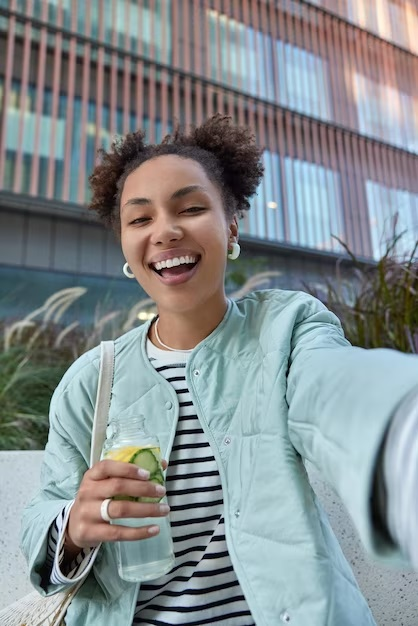

In [38]:
load_image("./dataset/a.jpg")

StableDiffusionControlNetInpaintPipeline was intended as an interface to use diffusion-based inpainting **and** ControlNet at the same time. However, by passing proper parameters, it is possible to use none, one, or both!

In our case, inpainting will be useful later for re-rendering the background. I will explain it later; for now let's just use it for plain ControlNet generation (control+text -> image). This can be achieved by providing full white inpainting mask (i.e. inpaint everything and disregard the initial image).

By the way, we can tune the degree to which the network follows the control by weighting the ControlNet outputs' addition, 0.0 (= control doesn't affect generation) to 1.0:

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

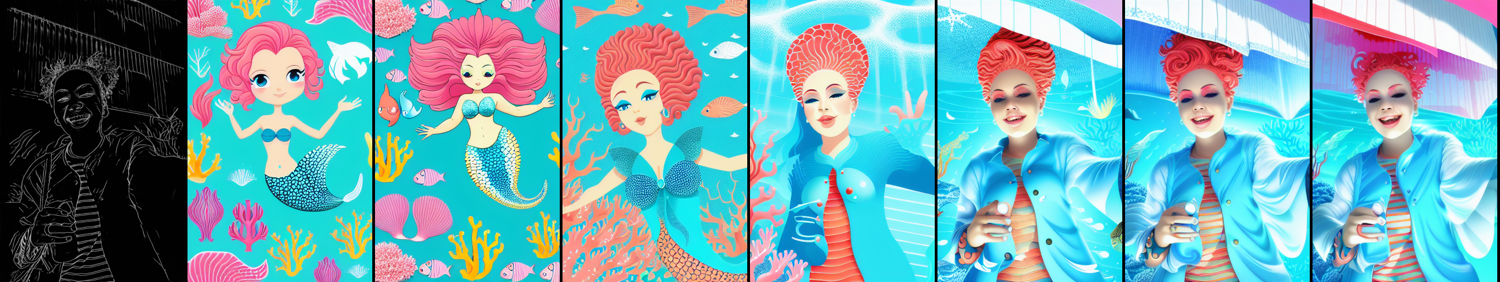

In [37]:
def text_to_image(prompt, control_image, **extra_diffusion_kwargs):
    diffusion_kwargs = dict(
        prompt=prompt,
        negative_prompt="worst quality, low quality, blurry, ugly",
        image=init_image,
        mask_image=Image.new('L', init_image.size, color='white'), # full white = inpainting switched off
        control_image=control_image,
        controlnet_conditioning_scale=0.85,  # 0.0 = lineart control switched off
        num_inference_steps=30,
        generator=torch.Generator(device=diffusion_pipeline.device).manual_seed(123),
    )
    diffusion_kwargs.update(extra_diffusion_kwargs)
    return diffusion_pipeline(**diffusion_kwargs).images[0]

init_image = sd15_image_transform(load_image("./dataset/a.jpg"))
control_image = get_control_image(init_image)
prompt = "mermaid underwater, blue clothes, corals and fishes background"

controlnet_scales = [0.0, 0.15, 0.3, 0.5, 0.7, 0.85, 1.0]
generated_images = [
    text_to_image(prompt, control_image, controlnet_conditioning_scale=c) for c in controlnet_scales
]
display_row([control_image] + generated_images)

## Specify the background in prompt (a stupid solution if we really have no time)

  0%|          | 0/30 [00:00<?, ?it/s]

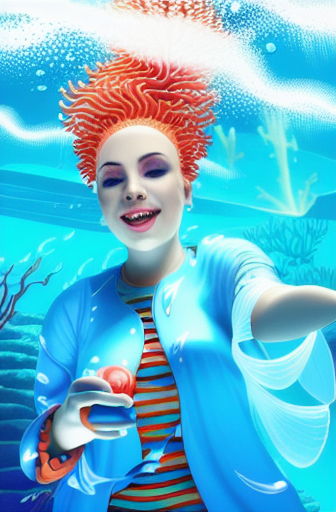

In [40]:
init_image = sd15_image_transform(load_image("./dataset/a.jpg"))
control_image = get_control_image(init_image)
prompt = "mermaid underwater, blue clothes, corals and fish in the background, vivid background with sea creatures, marine life"

text_to_image(prompt, control_image, controlnet_conditioning_scale=0.75)

Of course, the response isn't great. This could work with more advanced models that can follow complex prompts, but too much for SD 1.5.

We can use a good foreground segmentation algorithm like RMBG 1.4/2 to get a background mask and build something around it:

In [41]:
foreground_segm_model = transformers.pipeline(
    "image-segmentation",
    model="briaai/RMBG-1.4",
    trust_remote_code=True
)

Device set to use cuda:0


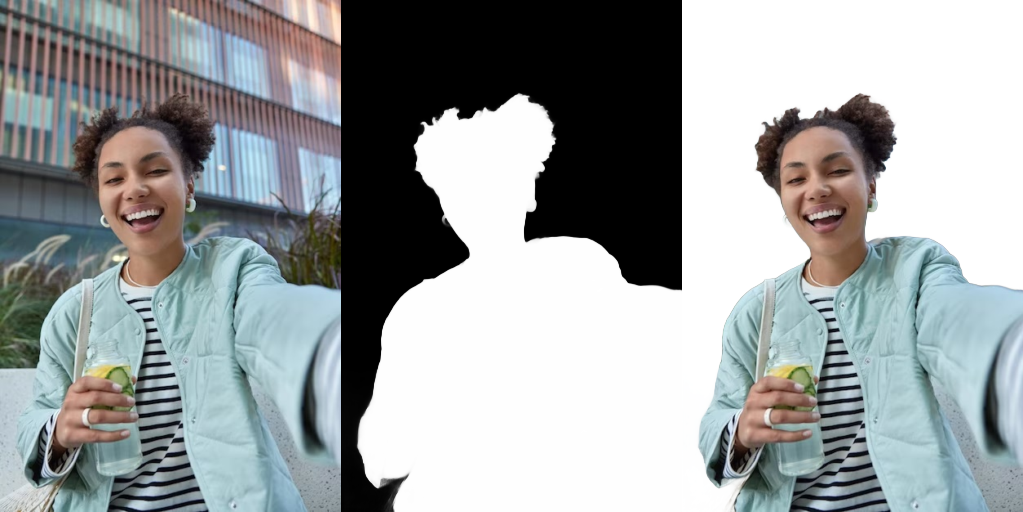

In [46]:
init_image = load_image("./dataset/a.jpg")
init_image = sd15_image_transform(init_image)
foreground_mask = foreground_segm_model(init_image, return_mask=True)

display_row([
    init_image,
    foreground_mask,
    Image.composite(init_image, Image.new('RGB', init_image.size, 'white'), foreground_mask)
])

## Erase background from the control image (a slightly less stupid solution if we have slightly more time)

In [134]:
init_image = load_image("./dataset/a.png")
init_image = sd15_image_transform(init_image)

control_image = get_control_image(init_image)
# this is the inverse of get_control_image
# it resizes to the closest multiple of 64, see controlnet_aux/util.py
control_image = control_image.resize(init_image.size)

foreground_mask = foreground_segm_model(init_image, return_mask=True)

control_image = Image.composite(
    control_image,
    Image.new('L', control_image.size, color='black'),
    foreground_mask
)

# generate image
prompts = [
    "a mountaineer on top of a snowy mountain",
    "mermaid underwater, blue clothes, corals and fishes background",
]
images = diffusion_pipeline(
    prompt=prompts,
    negative_prompt=["worst quality, low quality, blurry, ugly"] * len(prompts),
    image=init_image,
    mask_image=Image.new('L', init_image.size, color='white'),
    strength=1.0,
    control_image=control_image,
    controlnet_conditioning_scale=1.0,
    guidance_scale=7.5,
    eta=0.0,
    num_inference_steps=30,
    generator=torch.Generator(device="cuda").manual_seed(123),
).images

  0%|          | 0/30 [00:00<?, ?it/s]

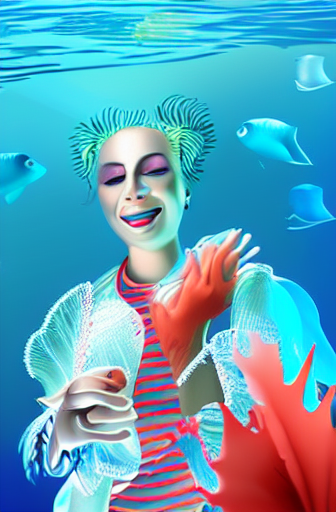

In [135]:
images[1]

# Inpaint background in init image

In [258]:
init_image = load_image("./dataset/a.png")
init_image = sd15_image_transform(init_image)

control_image = get_control_image(init_image)
# this is the inverse of get_control_image
# it resizes to the closest multiple of 64, see controlnet_aux/util.py
control_image = control_image.resize(init_image.size)

foreground_mask = foreground_segm_model(init_image, return_mask=True)
background_mask = ImageOps.invert(foreground_mask)

# generate image
prompts = [
    "a mountaineer on top of a snowy mountain",
    "mermaid underwater, blue clothes, corals and fishes background",
]
images = diffusion_pipeline(
    prompt=prompts,
    negative_prompt=["worst quality, low quality, blurry, ugly"] * len(prompts),
    image=init_image,
    mask_image=background_mask,
    strength=1.0,
    control_image=control_image,
    controlnet_conditioning_scale=0.0,
    guidance_scale=7.5,
    eta=0.0,
    num_inference_steps=30,
    padding_mask_crop=0,
    generator=torch.Generator(device="cuda").manual_seed(123),
).images

  0%|          | 0/30 [00:00<?, ?it/s]

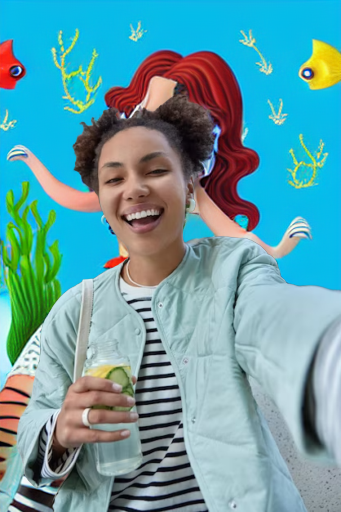

In [259]:
images[1]

In [5]:
def inpaint_simple(image, mask, mode="blur"):
    assert mode in ["average", "blur", "content-aware"]

    mask_PIL, mask = mask, np.array(mask)
    inpainted = np.array(image) # copy and convert to numpy
    if mode == "average":
        inpainted[mask > 128] = inpainted[mask > 128].mean(0).round().astype(np.uint8)
    elif mode == "blur":
        inpainted = cv2.GaussianBlur(
            inpainted,
            sigmaX=15,
            ksize=(45, 45),
            borderType=cv2.BORDER_REPLICATE
        )
    elif mode == "content-aware":
        inpainted = cv2.inpaint(
            inpainted,
            cv2.threshold(mask, 128, 255, cv2.CV_8U)[1],
            10,
            flags=cv2.INPAINT_TELEA
        )
        
    return Image.composite(
        image,
        Image.fromarray(inpainted),
        ImageOps.invert(mask_PIL)
    )

In [302]:
init_image = load_image("./dataset/a.png")
init_image = sd15_image_transform(init_image)

control_image = get_control_image(init_image)
# this is the inverse of get_control_image
# it resizes to the closest multiple of 64, see controlnet_aux/util.py
control_image = control_image.resize(init_image.size)

foreground_mask = foreground_segm_model(init_image, return_mask=True)
background_mask = ImageOps.invert(foreground_mask)

# generate image
prompts = [
    # "a mountaineer on top of a snowy mountain",
    "mermaid underwater, blue clothes, corals and fishes background, realistic",
    "a woman lying on a sandy beach",
]
images = diffusion_pipeline(
    prompt=prompts,
    negative_prompt=["worst quality, low quality, blurry, ugly"] * len(prompts),
    image=inpaint_simple(init_image, background_mask, mode="content-aware"),
    mask_image=background_mask,
    strength=1.0,
    control_image=control_image,
    controlnet_conditioning_scale=0.6,
    guidance_scale=7.5,
    eta=0.0,
    num_inference_steps=30,
    padding_mask_crop=0,
    generator=torch.Generator(device="cuda").manual_seed(123),
).images

  0%|          | 0/30 [00:00<?, ?it/s]

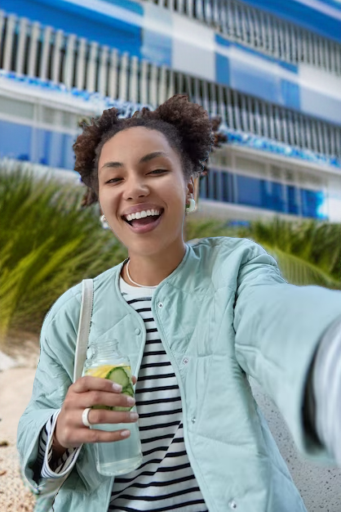

In [303]:
images[1]

## Stylize the foreground as well

In [45]:
init_image = load_image("./dataset/a.png")
init_image = sd15_image_transform(init_image)

control_image = get_control_image(init_image)
# this is the inverse of get_control_image
# it resizes to the closest multiple of 64, see controlnet_aux/util.py
control_image = control_image.resize(init_image.size)

foreground_mask = foreground_segm_model(init_image, return_mask=True)
background_mask = ImageOps.invert(foreground_mask)

control_image = Image.composite(
    control_image,
    Image.new('L', control_image.size, color='black'),
    foreground_mask
)

# generate image
prompts = [
    # "a mountaineer on top of a snowy mountain",
    "mermaid underwater, blue clothes, corals and fishes background, realistic",
    "a woman lying on a sandy beach",
]
images = diffusion_pipeline(
    prompt=prompts,
    negative_prompt=["worst quality, low quality, blurry, ugly"] * len(prompts),
    image=Image.new('RGB', init_image.size, color='black'), # inpaint_simple(init_image, background_mask, mode="content-aware"),
    mask_image=background_mask, # Image.new('L', init_image.size, color='white'),
    strength=1.0,
    control_image=control_image,
    controlnet_conditioning_scale=0.6,
    guidance_scale=7.5,
    eta=0.0,
    num_inference_steps=30,
    padding_mask_crop=None,
    generator=torch.Generator(device="cuda").manual_seed(123),
).images

  0%|          | 0/30 [00:00<?, ?it/s]

image = black

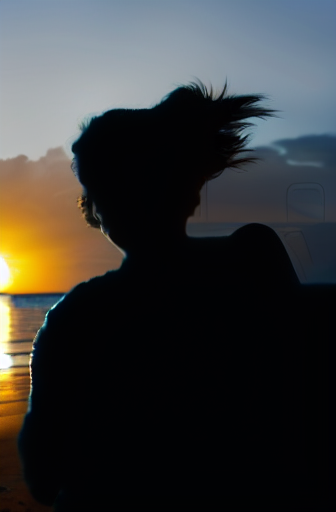

In [46]:
images[1]

image = white

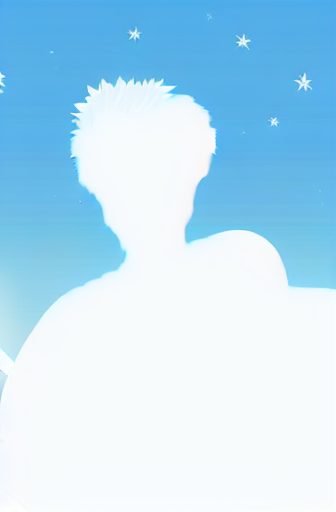

In [32]:
images[1]

In [20]:
init_image = load_image("./dataset/d.png")
init_image = sd15_image_transform(init_image)

control_image = get_control_image(init_image)
# this is the inverse of get_control_image
# it resizes to the closest multiple of 64, see controlnet_aux/util.py
control_image = control_image.resize(init_image.size)

foreground_mask = foreground_segm_model(init_image, return_mask=True)
background_mask = ImageOps.invert(foreground_mask)

control_image = Image.composite(
    control_image,
    Image.new('L', control_image.size, color='black'),
    foreground_mask
)

# generate image
prompts = [
    # "a mountaineer on top of a snowy mountain",
    "mermaid underwater, blue clothes, corals and fishes background",
    # "a woman lying on a sandy beach",
][0]

images = diffusion_pipeline(
    prompt=prompts,
    negative_prompt=["worst quality, low quality, blurry"][0],
    image=init_image,
    mask_image=Image.new('L', init_image.size, color='white'),
    strength=1.0,
    control_image=control_image,
    controlnet_conditioning_scale=1.0,
    guidance_scale=7.5,
    eta=0.0,
    num_inference_steps=30,
    padding_mask_crop=None,
    generator=torch.Generator(device="cuda").manual_seed(123),
).images[0]

foreground_stylized = images
# This image will have a slightly different size due to VaeImageProcessor.process' behavior.
# Resize back (restoring aspect ratio) because it's using resize_mode="default" here:
# https://github.com/huggingface/diffusers/blob/5873377a660dac60a6bd86ef9b4fdfc385305977/src/diffusers/pipelines/controlnet/pipeline_controlnet_inpaint.py#L1313
foreground_stylized = foreground_stylized.resize(init_image.size)

images = diffusion_pipeline(
    prompt="Milky Way, lots of stars, masterpiece, very beautiful, high quality",
    negative_prompt=["worst quality, low quality, blurry"][0],
    image=foreground_stylized,
    mask_image=background_mask,
    strength=1.0,
    control_image=control_image,
    controlnet_conditioning_scale=0.0,
    guidance_scale=7.5,
    eta=0.0,
    num_inference_steps=30,
    padding_mask_crop=0,
    generator=torch.Generator(device="cuda").manual_seed(123),
).images

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

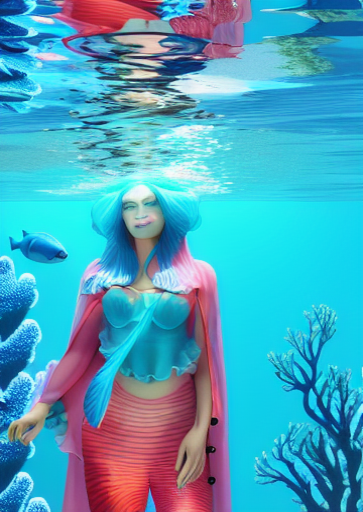

In [21]:
foreground_stylized

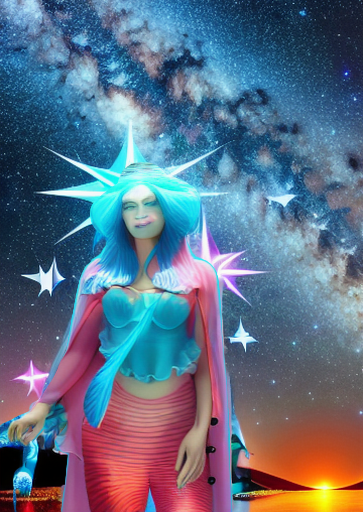

In [22]:
images[0]